In [24]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/working ViT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working import VisionTransformer as vit_old

In [25]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [26]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Idea

Optimization for a linear combination of similar tasks often yields models that are more accurate, generalize better and require less training data. A possible multi-task objective for TFM could be
<h3><center>$\mathcal{L} = \alpha_{1}$$\cdot MSE + \alpha_{2}$$\cdot DTMA + \alpha_{3}$$\cdot DDA$</center></h3>
where
<h3><center>$\boldsymbol\alpha > 0, \space\space\sum_{i=1}^{3} \alpha_{i} = 1$</center></h3>


Use parallel processing to scale up the data generating process.

In [16]:
dspl = np.zeros((0, 104, 104, 2))
trac_separated = np.zeros((0, 50, 104, 104, 2))

for i in range(1, 21):
    dspl_temp = h5py.File(f'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/extended data/displacements_{i}.h5')["data"]
    trac_separated_temp = h5py.File(f'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/extended data/sep_tractions_{i}.h5')["data"]
    dspl = np.append(dspl, dspl_temp, axis=0)
    trac_separated = np.append(trac_separated, trac_separated_temp, axis=0)

dspl_ = np.moveaxis(np.array(dspl[:, :, :, :]), 3, 1)
trac_separated_ = np.moveaxis(np.array(trac_separated[:, :, :, :]), 4, 2)

X_test = torch.from_numpy(dspl_).double().to(device)
trac_separated_test = torch.from_numpy(trac_separated_).double().to(device)

In [17]:
X_test.shape

torch.Size([200, 2, 104, 104])

In [23]:
for i in range(0, 200):
    for j in range(0, 200):
        if torch.all(X_test[i].eq(X_test[j])):
            print(f'i: {i}, j: {j}')

i: 0, j: 0
i: 1, j: 1
i: 2, j: 2
i: 3, j: 3
i: 4, j: 4
i: 5, j: 5
i: 6, j: 6
i: 7, j: 7
i: 8, j: 8
i: 9, j: 9
i: 10, j: 10
i: 11, j: 11
i: 12, j: 12
i: 13, j: 13
i: 14, j: 14
i: 15, j: 15
i: 16, j: 16
i: 17, j: 17
i: 18, j: 18
i: 19, j: 19
i: 20, j: 20
i: 21, j: 21
i: 22, j: 22
i: 23, j: 23
i: 24, j: 24
i: 25, j: 25
i: 26, j: 26
i: 27, j: 27
i: 28, j: 28
i: 29, j: 29
i: 30, j: 30
i: 31, j: 31
i: 32, j: 32
i: 33, j: 33
i: 34, j: 34
i: 35, j: 35
i: 36, j: 36
i: 37, j: 37
i: 38, j: 38
i: 39, j: 39
i: 40, j: 40
i: 41, j: 41
i: 42, j: 42
i: 43, j: 43
i: 44, j: 44
i: 45, j: 45
i: 46, j: 46
i: 47, j: 47
i: 48, j: 48
i: 49, j: 49
i: 50, j: 50
i: 51, j: 51
i: 52, j: 52
i: 53, j: 53
i: 54, j: 54
i: 55, j: 55
i: 56, j: 56
i: 57, j: 57
i: 58, j: 58
i: 59, j: 59
i: 60, j: 60
i: 61, j: 61
i: 62, j: 62
i: 63, j: 63
i: 64, j: 64
i: 65, j: 65
i: 66, j: 66
i: 67, j: 67
i: 68, j: 68
i: 69, j: 69
i: 70, j: 70
i: 71, j: 71
i: 72, j: 72
i: 73, j: 73
i: 74, j: 74
i: 75, j: 75
i: 76, j: 76
i: 77, j: 77
i: 78,

In [44]:
trac_separated_test.shape

torch.Size([200, 50, 2, 104, 104])

<IPython.core.display.Javascript object>


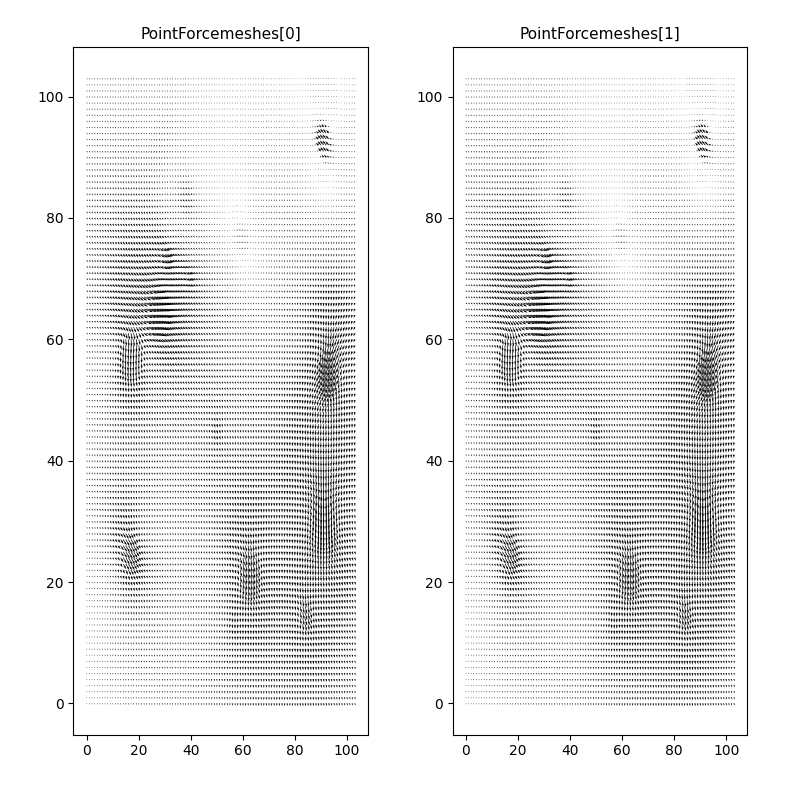

Text(0.5, 1.0, 'PointForcemeshes[1]')

In [50]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,2, figsize=(8, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0, 1, :, :], scale=1)
axs[0].set_title('PointForcemeshes[0]', {'fontsize': 11})

trac_test = torch.sum(trac_separated_test, dim=1)

axs[1].quiver(X_test[10, 0, :, :], X_test[10, 1, :, :], scale=1)
axs[1].set_title('PointForcemeshes[1]', {'fontsize': 11})

In [9]:
vit_weights = vit_old(dspl_size=104,
                      patch_size=8,
                      embed_dim=128,
                      depth=12,
                      n_heads=8,
                      mlp_ratio=4.,
                      p=0.,
                      attn_p=0.,
                      drop_path=0.).double()

In [10]:
path_to_pth = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working_ViT/logs_and_weights/ViT-2022-Dec-10 23:18:41/ViT-2022-Dec-10 23:18:41_best_val_loss_2.365828e-06.pth'

In [11]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [12]:
dspl = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/data_with_patch_info/test_sep_displacements.h5')["data"]
trac_separated = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/data_with_patch_info/test_sep_tractions.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl[:, :, :, :]),3 ,1)
trac_separated_ = np.moveaxis(np.array(trac_separated[:, :, :, :]),4, 2)

X_test = torch.from_numpy(dspl_).double().to(device)
trac_separated_test = torch.from_numpy(trac_separated_).double().to(device)

In [5]:
print(X_test.shape)
print(trac_separated_test.shape)

NameError: name 'X_test' is not defined

In [16]:
vit_weights.eval()
pred_vit = vit_weights(X_test[:, :, :, :])
# pred_cnn = cnn_weights.predict(dspl[0:50, :, :, :])

In [17]:
pred_vit.shape

torch.Size([5, 2, 104, 104])

<IPython.core.display.Javascript object>


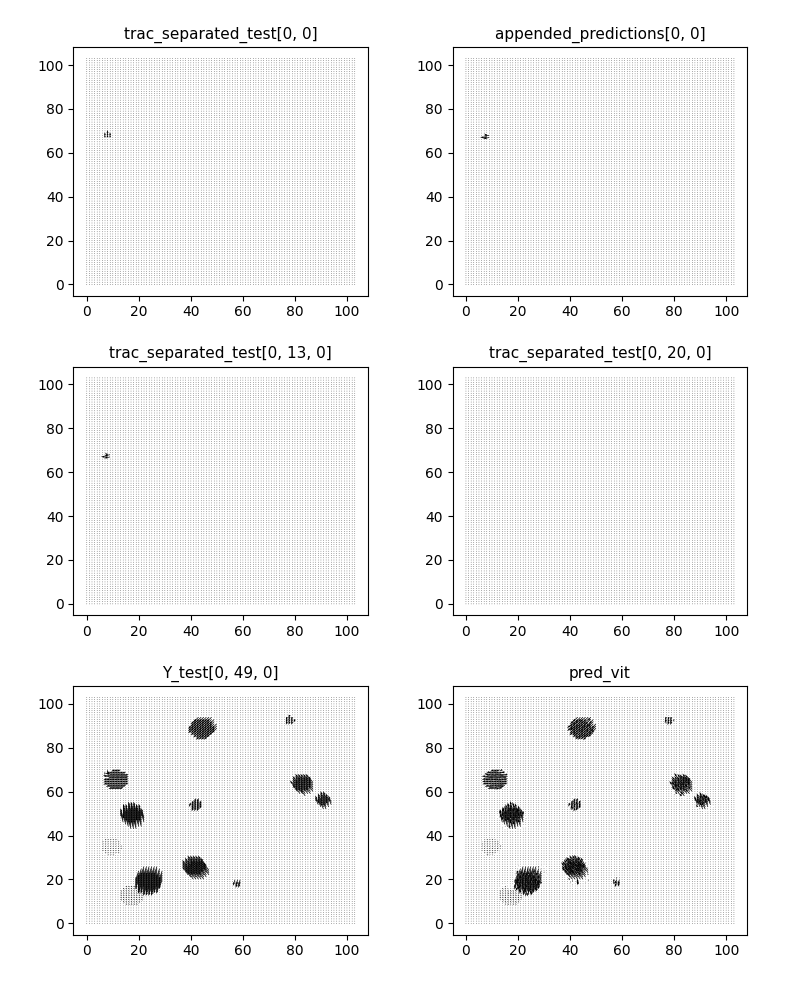

Text(0.5, 1.0, 'pred_vit')

In [815]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(3,2, figsize=(8, 10))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(trac_separated_test[0, 7, 0, :, :].detach().numpy(), trac_separated_test[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[0, 0].set_title('trac_separated_test[0, 0]', {'fontsize': 11})

axs[0, 1].quiver(appended_predictions[0, 7, 0, :, :].detach().numpy(), appended_predictions[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[0, 1].set_title('appended_predictions[0, 0]', {'fontsize': 11})

axs[1, 0].quiver(appended_predictions[0, 7, 0, :, :].detach().numpy(), appended_predictions[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[1, 0].set_title('trac_separated_test[0, 13, 0]', {'fontsize': 11})

axs[1, 1].quiver(appended_predictions[0, 20, 0, :, :].detach().numpy(), appended_predictions[0, 20, 1, :, :].detach().numpy(), scale=10)
axs[1, 1].set_title('trac_separated_test[0, 20, 0]', {'fontsize': 11})

axs[2, 0].quiver(Y_test[0, 0, :, :].detach().numpy(), Y_test[0, 1, :, :].detach().numpy(), scale=13)
axs[2, 0].set_title('Y_test[0, 49, 0]', {'fontsize': 11})

axs[2, 1].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=13)
axs[2, 1].arrow(43, 18, Y_test[0, 0, 43, 18], 1,fc='red')
axs[2, 1].set_title('pred_vit', {'fontsize': 11})

In [569]:
dtma_ex = dtma(appended_predictions, trac_separated_test)

In [570]:
dtma_ex

tensor(-0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [550]:
trac_separated_test[:,:].shape

torch.Size([10, 50, 2, 104, 104])

In [549]:
dtma_ex

tensor([-0.0254, -0.0162, -0.0254, -0.0178, -0.0254, -0.0323, -0.0222, -0.0237,
        -0.0197, -0.0296], grad_fn=<MulBackward0>)

In [546]:
pred_vit.shape

torch.Size([10, 2, 104, 104])

In [547]:
trac_separated_test.shape

torch.Size([10, 50, 2, 104, 104])

<IPython.core.display.Javascript object>


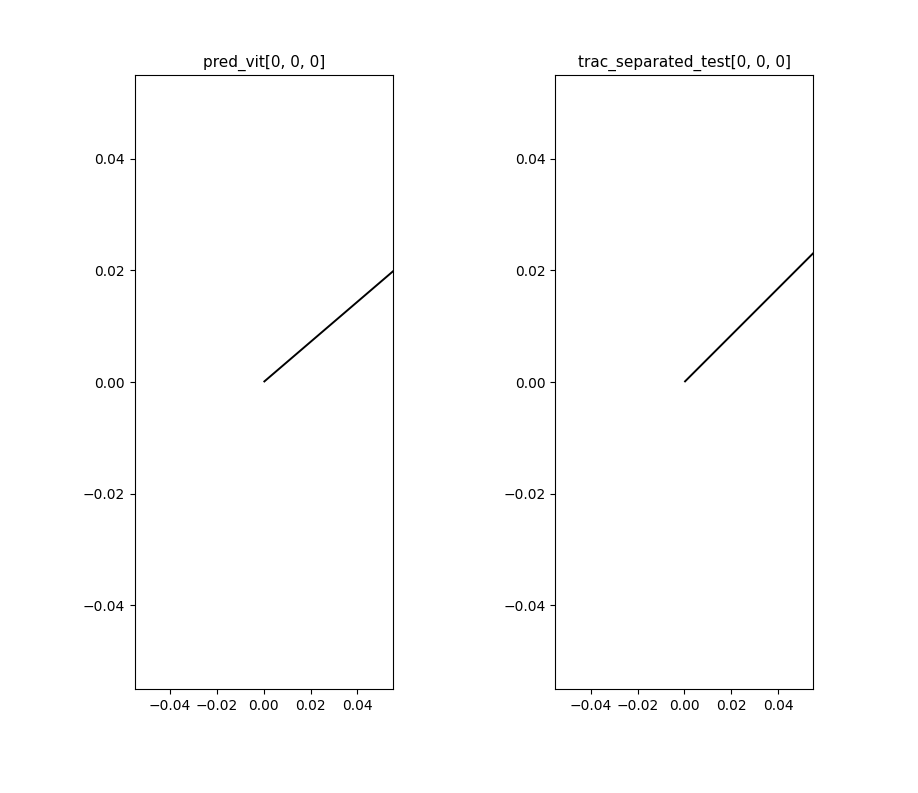

Text(0.5, 1.0, 'trac_separated_test[0, 0, 0]')

In [748]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(pred_vit[0, 0, 35, 12].detach().numpy(), pred_vit[0, 1, 35, 12].detach().numpy(), scale=0.05)
axs[0].set_title('pred_vit[0, 0, 0]', {'fontsize': 11})

axs[1].quiver(Y_test[0, 0, 35, 12].detach().numpy(), Y_test[0, 0, 35, 12].detach().numpy(), scale=0.05)
axs[1].set_title('trac_separated_test[0, 0, 0]', {'fontsize': 11})